# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [35]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import f1_score
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

import torch.nn as nn

from tqdm.notebook import tqdm

### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [36]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST("",train = True, download = True, transform = transform) #TODO use datasets.MNIST
testset = datasets.MNIST("",train = False, download = True, transform = transform) #TODO

In [37]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1
                                                     , shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, num_workers = 2) #TODO

tensor(0)


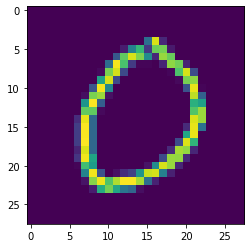

In [38]:
def visualise(img):
    plt.imshow(img)

for data in trainloader_minibatch:
    print(data[1][2])  # 1 means label
    visualise(data[0][2][0]) # 0 means image
    # print()
    break

In [39]:
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 0/938 [00:00<?, ?it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [40]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP,self).__init__()
        # code here
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self,x):
        # code here
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # no activation since we use cross entropy loss
        return x

In [41]:
model = SimpleMLP()
loss_criteria = nn.CrossEntropyLoss()
epoch_count = 5
learning_rate = 0.001

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [42]:
def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [43]:
train_actual = []
test_actual = []
for batch in trainloader_minibatch:
    train_actual.append(batch[1])
for batch in testloader:
    test_actual.append(batch[1])
train_actual = torch.cat(train_actual)
train_actual = train_actual.numpy()
test_actual = torch.cat(test_actual)
test_actual = test_actual.numpy()


In [45]:
def train(model,loss_criteria, epoch_count, optimizer):
    optimizer = optimizer
    train_loss_per_optimizer = []
    test_loss_per_optimizer = []

    train_losses = []
    test_losses = []
    test_f1_scores = []

    for _ in range(epoch_count):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader_minibatch, 0):
            inputs, labels = data
            optimizer.zero_grad() 
            outputs = model(inputs)
            loss = loss_criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_per_optimizer.append(running_loss / len(trainloader_minibatch))

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = loss_criteria(outputs, labels)
                test_loss += loss.item()
            test_loss /= len(testloader)
            test_loss_per_optimizer.append(test_loss)
    
    total = 0
    correct = 0
    running_loss = 0.0
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_criteria(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_f1 = f1_score(test_targets, test_preds, average='macro')
            test_f1_scores.append(test_f1)
    test_loss_per_optimizer.append(running_loss / len(testloader))
    train_losses.append(train_loss_per_optimizer)
    test_losses.append(test_loss_per_optimizer)
    
    print("Optimizer:", optimizer)
    print("Test accuracy:", 100 * correct / total)
    print("Train loss:", train_loss_per_optimizer[-1])
    print("Test loss:", test_loss_per_optimizer[-1])
    print("F1 Score:", test_f1_scores[-1])

    return train_loss_per_optimizer, test_loss_per_optimizer, test_preds, test_targets, test_f1_scores

SGD

In [30]:
SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
SGD_trainLossPerEpoch, SGD_testLossPerEpoch, SGD_test_pred, SGD_test_target, SGD_test_f1  = train(model,loss_criteria, epoch_count, SGD_optimizer)

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Test accuracy: 60.75
Train loss: 2.0418313646367365
Test loss: 1.9590604229337851
F1 Score: 0.5672409489957448


In [13]:
# plot_loss(trainLossPerEpoch)
# plot_loss(testLossPerEpoch)

SGD with momentum

In [14]:
SGDMomentum_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
SGDMomentum_trainLossPerEpoch, SGDMomentum_testLossPerEpoch, SGDMomentum_test_pred, SGDMomemtum_test_target, SGDMomemtum_test_f1 = train(model,loss_criteria, epoch_count, SGDMomentum_optimizer)

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Test accuracy: 91.5
Train loss: 0.3103056299184431
Test loss: 0.28842364076026683
F1 Score: 0.913416215775697


SGD with L2 regularization

In [15]:
SGDL2_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)
SGDL2_trainLossPerEpoch, SGDL2_testLossPerEpoch, SGDL2_test_pred, SGDL2_test_target, SGDL2_test_f1 = train(model,loss_criteria, epoch_count, SGDL2_optimizer)

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.0001
)
Test accuracy: 92.13
Train loss: 0.28659668882518435
Test loss: 0.280096477099285
F1 Score: 0.9199588944702995


RMS Prop

In [16]:
RMS_optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
RMS_trainLossPerEpoch, RMS_testLossPerEpoch, RMS_test_pred, RMS_test_target, RMS_test_f1 = train(model,loss_criteria, epoch_count, RMS_optimizer)

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Test accuracy: 97.96
Train loss: 0.04309302922224066
Test loss: 0.06370823285216169
F1 Score: 0.9794567987449115


Adam Optimizer

In [46]:
# code here
adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
Adam_trainLossPerEpoch, Adam_testLossPerEpoch, Adam_test_pred, Adam_test_target, Adam_test_f1 = train(model,loss_criteria, epoch_count, adam_optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Test accuracy: 97.36
Train loss: 0.06084514077011147
Test loss: 0.08408489205821115
F1 Score: 0.9735321976748912


### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

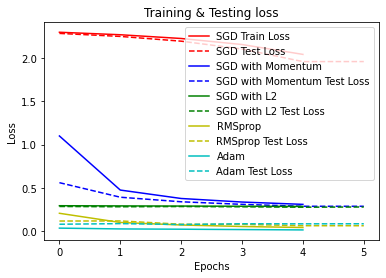

In [33]:
# code, plots and explainiation here
epochs = range(1, epoch_count+1)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(SGD_trainLossPerEpoch, 'r', label='SGD Train Loss')
plt.plot(SGD_testLossPerEpoch, 'r--', label='SGD Test Loss')
plt.plot(SGDMomentum_trainLossPerEpoch, 'b', label='SGD with Momentum')
plt.plot(SGDMomentum_testLossPerEpoch, 'b--', label='SGD with Momentum Test Loss')
plt.plot(SGDL2_trainLossPerEpoch, 'g', label='SGD with L2')
plt.plot(SGDL2_testLossPerEpoch, 'g--', label='SGD with L2 Test Loss')
plt.plot(RMS_trainLossPerEpoch, 'y', label='RMSprop')
plt.plot(RMS_testLossPerEpoch, 'y--', label='RMSprop Test Loss')
plt.plot(Adam_trainLossPerEpoch, 'c', label='Adam')
plt.plot(Adam_testLossPerEpoch, 'c--', label='Adam Test Loss')
plt.title('Training & Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


***Observation***
: SGD converges very slow but on adding Momemtum it converges fast for our data. SGD with regularization since prevents overfitting, it works well for our testing data. RMS Prop and Adam are performing quite better for our data and among them Adam is performing the best.

### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

In [47]:
# code and analysis here
def train_and_evaluate(model, optimizer, lr_scheduler=None):
    
    train_loss_lis = []
    test_losses_lis = []

    for epoch in range(10):

        model.train()
        train_loss = 0
        for data, target in trainloader_minibatch:
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        train_loss = train_loss/len(trainloader_minibatch.dataset)
        train_loss_lis.append(train_loss)

        if lr_scheduler is not None:
            lr_scheduler.step()
        
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in testloader:
                output = model(data)
                test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
        test_loss /= len(testloader.dataset)
        test_losses_lis.append(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {correct/len(testloader.dataset):.4f}')
    
    return train_loss_lis, test_losses_lis

In [48]:
step = lr_scheduler.MultiStepLR(adam_optimizer, milestones=[30,80], gamma=0.1)
exponential = lr_scheduler.ExponentialLR(adam_optimizer, gamma=0.1)

train_loss1, test_loss1 = train_and_evaluate(model, adam_optimizer, step)
train_loss2, test_loss2 = train_and_evaluate(model, adam_optimizer, exponential)
train_loss3, test_loss3 = train_and_evaluate(model, adam_optimizer)

Epoch 1/range(1, 6), Train Loss: 0.0475, Test Loss: 0.0779, Test Acc: 0.9759
Epoch 2/range(1, 6), Train Loss: 0.0391, Test Loss: 0.0781, Test Acc: 0.9766
Epoch 3/range(1, 6), Train Loss: 0.0324, Test Loss: 0.0722, Test Acc: 0.9803
Epoch 4/range(1, 6), Train Loss: 0.0262, Test Loss: 0.0849, Test Acc: 0.9775
Epoch 5/range(1, 6), Train Loss: 0.0231, Test Loss: 0.0822, Test Acc: 0.9784
Epoch 6/range(1, 6), Train Loss: 0.0195, Test Loss: 0.0806, Test Acc: 0.9792
Epoch 7/range(1, 6), Train Loss: 0.0170, Test Loss: 0.0817, Test Acc: 0.9784
Epoch 8/range(1, 6), Train Loss: 0.0163, Test Loss: 0.0957, Test Acc: 0.9759
Epoch 9/range(1, 6), Train Loss: 0.0120, Test Loss: 0.0916, Test Acc: 0.9778
Epoch 10/range(1, 6), Train Loss: 0.0137, Test Loss: 0.0914, Test Acc: 0.9798
Epoch 1/range(1, 6), Train Loss: 0.0126, Test Loss: 0.0960, Test Acc: 0.9780
Epoch 2/range(1, 6), Train Loss: 0.0039, Test Loss: 0.0808, Test Acc: 0.9812
Epoch 3/range(1, 6), Train Loss: 0.0018, Test Loss: 0.0808, Test Acc: 0.981

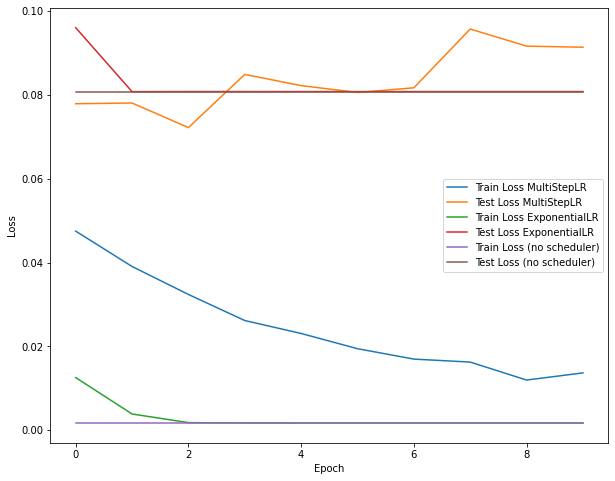

In [52]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.plot(train_loss1, label='Train Loss MultiStepLR')
plt.plot(test_loss1, label='Test Loss MultiStepLR')
plt.plot(train_loss2, label='Train Loss ExponentialLR')
plt.plot(test_loss2, label='Test Loss ExponentialLR')
plt.plot(train_loss3, label='Train Loss (no scheduler)')
plt.plot(test_loss3, label='Test Loss (no scheduler)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [53]:
# code here
class MLP_BatchNorm(nn.Module):
    def __init__(self):
        super(MLP_BatchNorm, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x

class MLP_Dropout(nn.Module):
    def __init__(self):
        super(MLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    

class MLP_Both(nn.Module):
    def __init__(self):
        super(MLP_Both,self).__init__()
        self.fc1 = nn.Linear(784, 512)  
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)  
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, 10)   
        self.relu = nn.ReLU()

    def forward(self,x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)    
        x = self.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)   
        x = self.fc3(x)     
        return x

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

In [54]:
# code here
# code here
BN_model = MLP_BatchNorm()
adamBN_optimizer = torch.optim.Adam(BN_model.parameters(), lr=0.01)

DR_model = MLP_Dropout()
adamDR_optimizer = torch.optim.Adam(DR_model.parameters(), lr=0.01)

Both_model = MLP_Both()
adamBoth_optimizer = torch.optim.Adam(Both_model.parameters(), lr=0.01)


train_loss0, test_loss0 = train_and_evaluate(model, adam_optimizer)
train_loss1, test_loss1 = train_and_evaluate(BN_model, adamBN_optimizer)
train_loss2, test_loss2 = train_and_evaluate(DR_model, adamDR_optimizer)
train_loss3, test_loss3 = train_and_evaluate(Both_model, adamBoth_optimizer)

Epoch 1/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 2/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 3/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 4/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 5/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 6/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 7/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 8/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 9/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 10/range(1, 6), Train Loss: 0.0017, Test Loss: 0.0808, Test Acc: 0.9816
Epoch 1/range(1, 6), Train Loss: 0.1979, Test Loss: 0.1022, Test Acc: 0.9689
Epoch 2/range(1, 6), Train Loss: 0.0991, Test Loss: 0.0799, Test Acc: 0.9754
Epoch 3/range(1, 6), Train Loss: 0.0741, Test Loss: 0.0822, Test Acc: 0.973

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

In [57]:
# code here
# code here
def train_and_evaluate2(model, optimizer, lr_scheduler=None, trainloader = trainloader_minibatch):

    train_losses = []
    test_losses = []

    for epoch in range(25):

        model.train()
        train_loss = 0
        for data, target in trainloader_minibatch:
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        train_loss = train_loss/len(trainloader_minibatch.dataset)
        train_losses.append(train_loss)

        if lr_scheduler is not None:
            lr_scheduler.step()
        
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in testloader:
                output = model(data)
                test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
        test_loss /= len(testloader.dataset)
        test_losses.append(test_loss)

        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1}/{25}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {correct/len(testloader.dataset):.4f}')

        
    print("*********************************************")
    if(trainloader == trainloader_minibatch):
        print("Loader: Minibatch",)
    else:
        print("Loader: Stochastic")
    print("Test accuracy:", 100 * correct / len(testloader.dataset))
    print("Train loss:", train_losses[-1])
    print("Test loss:", test_losses[-1])
    # print("F1 Score:", test_f1_scores[-1])
    print("*********************************************")

    
    return train_losses, test_losses


In [58]:
train_loss1, test_loss1 = train_and_evaluate2(BN_model, adamBN_optimizer, step, trainloader_minibatch)
train_loss2, test_loss2 = train_and_evaluate2(BN_model, adamBN_optimizer, step, trainloader_stochastic)

Epoch 5/25, Train Loss: 0.0111, Test Loss: 0.0970, Test Acc: 0.9837
Epoch 10/25, Train Loss: 0.0111, Test Loss: 0.1200, Test Acc: 0.9818
Epoch 15/25, Train Loss: 0.0089, Test Loss: 0.1240, Test Acc: 0.9828
Epoch 20/25, Train Loss: 0.0089, Test Loss: 0.1281, Test Acc: 0.9820
Epoch 25/25, Train Loss: 0.0089, Test Loss: 0.1182, Test Acc: 0.9838
*********************************************
Loader: Minibatch
Test accuracy: 98.38
Train loss: 0.008912535004558441
Test loss: 0.11818007385964883
*********************************************
Epoch 5/25, Train Loss: 0.0083, Test Loss: 0.1198, Test Acc: 0.9839
Epoch 10/25, Train Loss: 0.0083, Test Loss: 0.1501, Test Acc: 0.9825
Epoch 15/25, Train Loss: 0.0096, Test Loss: 0.1227, Test Acc: 0.9851
Epoch 20/25, Train Loss: 0.0085, Test Loss: 0.1303, Test Acc: 0.9843
Epoch 25/25, Train Loss: 0.0070, Test Loss: 0.1410, Test Acc: 0.9847
*********************************************
Loader: Stochastic
Test accuracy: 98.47
Train loss: 0.00702551501479357

In [59]:
for i in range(len(test_loss1)):
    print(test_loss1[i] - test_loss2[i])

0.00376664932039239
-0.03798491158876287
-0.024925083445540813
-0.021688004424818247
-0.02282472874636246
-0.012958251964051065
-0.012735843786054413
-0.008036853805893043
-0.029818564018875254
-0.030038914570806263
-0.015191544914963856
-0.03299574997422006
-0.009846160983182112
-0.05429835272289457
0.0012738984774750828
-0.021407072030709698
-0.047706445691491156
-0.022821691962318466
-0.036878989436750345
-0.0022481002958758545
-0.025382563160367855
-0.028945066934600305
-0.025236649666341482
-0.003673625371253736
-0.022774877879416552


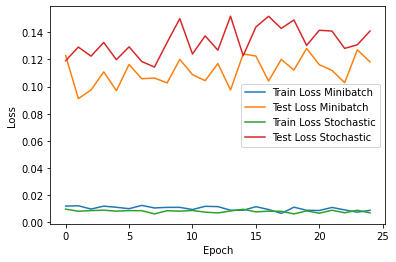

In [60]:
plt.plot(train_loss1, label='Train Loss Minibatch')
plt.plot(test_loss1, label='Test Loss Minibatch')
plt.plot(train_loss2, label='Train Loss Stochastic')
plt.plot(test_loss2, label='Test Loss Stochastic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

We learned applying MLP to MNIST dataset. We also learned how to use Batch Normalization and Dropout to improve the performance of MLP. We also learned how to use Stochastic Gradient Descent to train the model. 
We also compared the performance of different optimizers and found that Adam optimizer is the best optimizer for our data. We also compared the performance of different learning rate schedulers and found its impact on results. We also compared the performance of mini-batch and stochastic gradient descent and found its impact on results.